## Breast Cancer Dataset: Tutorial and Examples

### **Imports**

In [1]:
import pandas as pd
import numpy as np

from mlbugdetection.load_data import load_dataset
from mlbugdetection.monotonic import monotonicity_mse, check_monotonicity_single_sample, check_monotonicity_multiple_samples
from mlbugdetection.critical_values import highest_and_lowest_indexes, find_critical_values, find_several_critical_values
from mlbugdetection.calibration import calibration_check
from mlbugdetection.sanity import sanity_check, sanity_check_with_indexes

### **Load Data**
#### First, divide the data into the categories of malignant and benign tumors

In [2]:
df = load_dataset()
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
mal = df[df.diagnosis == "M"]
ben = df[df.diagnosis == "B"]

In [4]:
X_ben = ben.drop(columns=["diagnosis"])
X_ben.drop('id', axis=1, inplace=True) #drop redundant columns
X_mal = mal.drop(columns=["diagnosis"])
X_mal.drop('id', axis=1, inplace=True) #drop redundant columns

In [5]:
single_sample_ben = X_ben.sample(1, random_state=42)
single_sample_mal = X_mal.sample(1, random_state=42)

In [6]:
sample_ben = X_ben.sample(100, random_state=42)
sample_mal = X_mal.sample(100, random_state=23)


### Load the trained models that will be analyzed

In [7]:
model_path_knn = "models/KNN/KNNBreastCancer.pkl"
model_path_nn = "models/NN/NNBreastCancer.pkl"

### **Monotonicity analysis**
#### The monotonicity analysis module has two main functions: *check_monotonicity_single_sample* and *check_monotonicity_multiple_samples*.
#### The function *check_monotonicity_single_sample* receives a model, a single sample (one dataframe row), the feature that will be analyzed, the value interval of this feature, and the number of points analysed between this interval
#### The graph bellow shows that for a random sample of a benign tumor, the feature *perimeter_mean* has a monotonic behavior related to the prediction probability between the ranges 0 and 2000 using a MPLClassifier

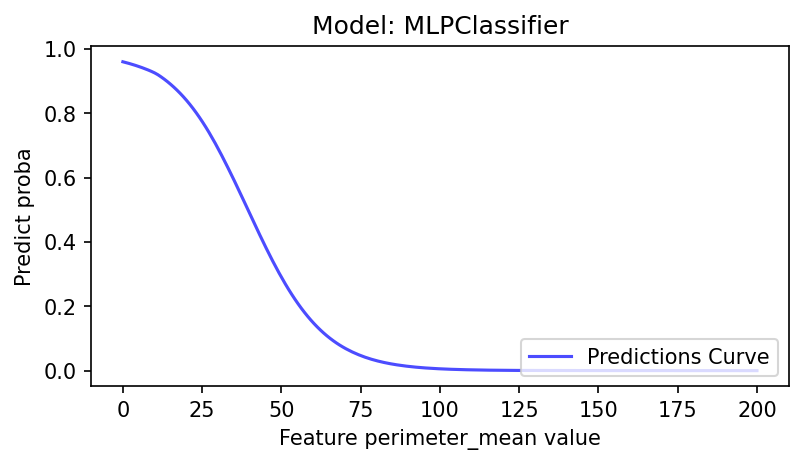

In [8]:
report_ben_mono = check_monotonicity_single_sample(model_path_nn, single_sample_ben, "perimeter_mean", 0,200,200)

#### For a similar example, but from a sample of a malignant tumor, the same feature presents a monotonic behavior as well

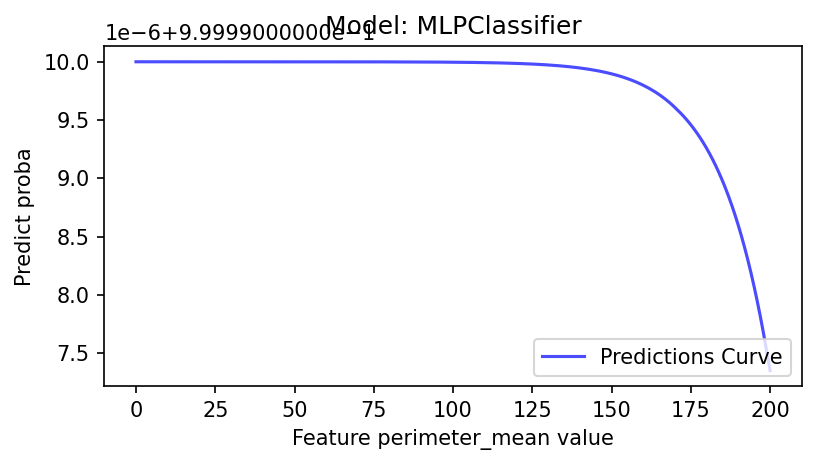

In [9]:
report_mal_mono = check_monotonicity_single_sample(model_path_nn, single_sample_mal, "perimeter_mean", 0,200,200)

#### The function *check_monotonicity_multiple_samples* receives a model, a sample containing multiple dataframe rows, the feature that will be analyzed, the value interval of this feature, and the number of points analysed between this interval
#### The graph bellow shows the mean prediction probability of the whole sample for each point analysed. In this case, the feature *area_mean* does not have a monotonic relationship with the mean prediction probability.

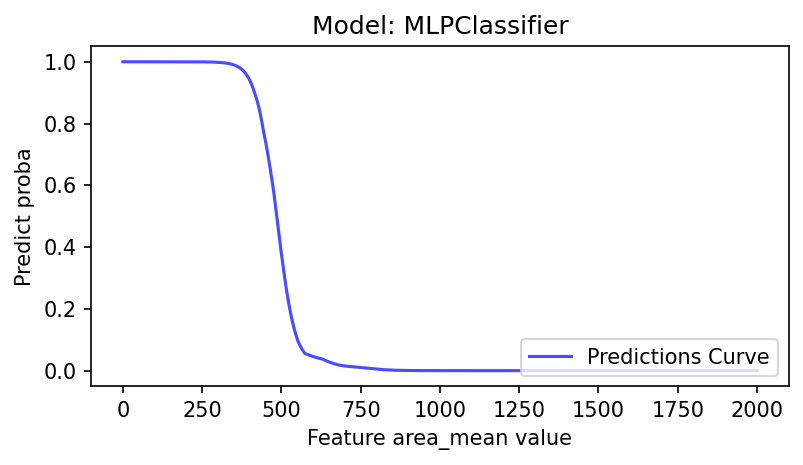

In [10]:
report_ben_mono_mult_nn = check_monotonicity_multiple_samples(model_path_nn, X_ben, "area_mean", 0,2000,2000)

#### It is hard to identify how close the data is to a monotonic behavior only visualizing the graph. The method "monotonic_score" of the analysis report helps identifying it.

In [11]:
report_ben_mono_mult_nn.metrics

{'monotonic': True,
 'monotonic_score': 1,
 'monotonic_means_std': 0.40909039060003954}

#### The MSE between the aproximated monotonic curve and the real curve is so small that it is possible to consider the real curve as monotonic.
#### Running the same sample in a KNN model shows a completely different result.

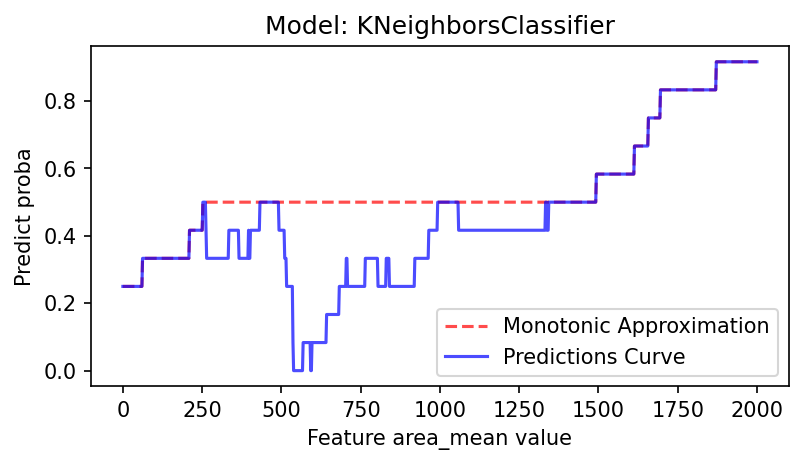

In [12]:
report_ben_mono_mult_knn = check_monotonicity_multiple_samples(model_path_knn, X_ben, "area_mean", 0,2000,1000)

In [13]:
report_ben_mono_mult_knn.metrics

{'monotonic': False,
 'monotonic_score': 0.023347222222222224,
 'monotonic_means_std': 0.22148463703933158}

### **Critical values analysis**
#### The critical values analysis module has two main functions: *find_critical_values* and *find_several_critical_values*.
#### The analysed feature will be again *area_mean*, and this module identifies data examples and feature ranges that generate the biggest changes in the model's prediction probability, which can sometimes result in classification changes.


In [14]:
#First it will be analysed the model's behavior using the feature range from the training data
min_v = df["perimeter_mean"].min()
max_v = df["perimeter_mean"].max()

Positive means:
	Mean: 0.0
	Median: 0.0
	Standard Deviation: 0.0
	Variance: 0.0
Negative means:
	Mean: -0.00300242825636691
	Median: -0.00019471448965988403
	Standard Deviation: 0.0036000411201157676
	Variance: 1.2960296066524391e-05


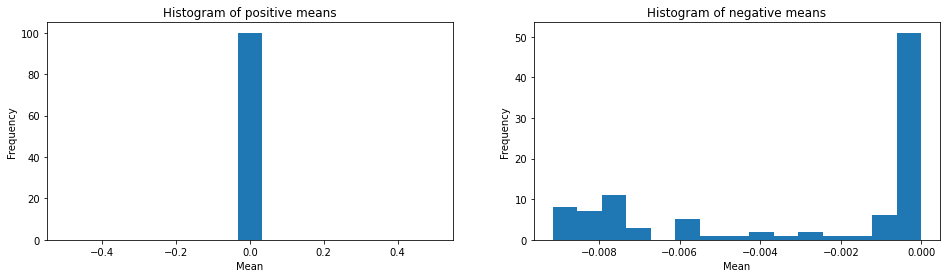

In [15]:
teste2 = find_several_critical_values(model_path_nn, sample_mal, "perimeter_mean",min_v,max_v,200, keep_n = 100)

Positive means:
	Mean: 9.129090818062485e-07
	Median: 0.0
	Standard Deviation: 2.195248590056286e-06
	Variance: 4.819116372144111e-12
Negative means:
	Mean: -0.0030623084509811727
	Median: -0.0019462544641158767
	Standard Deviation: 0.002940666856262408
	Variance: 8.647521559520235e-06


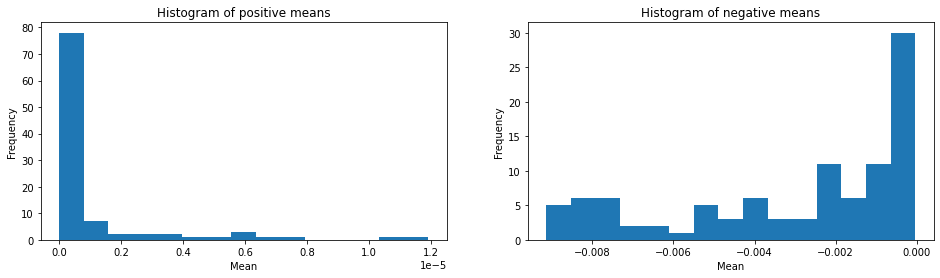

In [16]:
teste3 = find_several_critical_values(model_path_nn, sample_ben, "perimeter_mean", min_v,max_v,200, keep_n = 100)

In [17]:
print(len(teste2.metrics["critical_indexes"]))
print(len(teste3.metrics["critical_indexes"]))

35
27


Positive means:
	Mean: 1.939321484249708e-07
	Median: 0.0
	Standard Deviation: 8.70063122586648e-07
	Variance: 7.570098372852284e-13
Negative means:
	Mean: -0.007827771608320013
	Median: -0.00997584931530002
	Standard Deviation: 0.003996778455451478
	Variance: 1.5974238021961105e-05


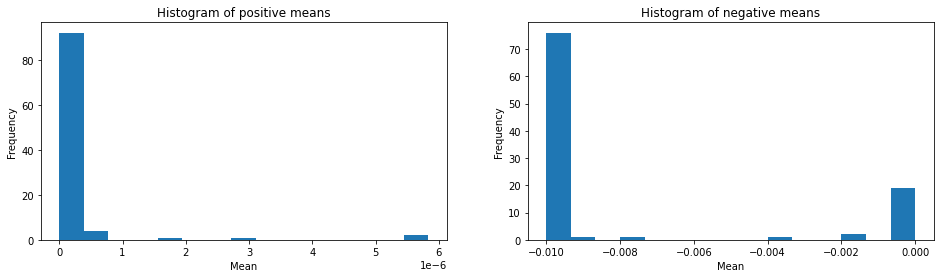

In [18]:
teste4 = find_several_critical_values(model_path_nn, sample_mal, "perimeter_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),200, keep_n = 100)

Positive means:
	Mean: 2.7961777622763534e-06
	Median: 9.721731098652149e-07
	Standard Deviation: 5.096600645552434e-06
	Variance: 2.5975338140245488e-11
Negative means:
	Mean: -0.009419174628108835
	Median: -0.009813336369934828
	Standard Deviation: 0.0009242767266763225
	Variance: 8.542874674754975e-07


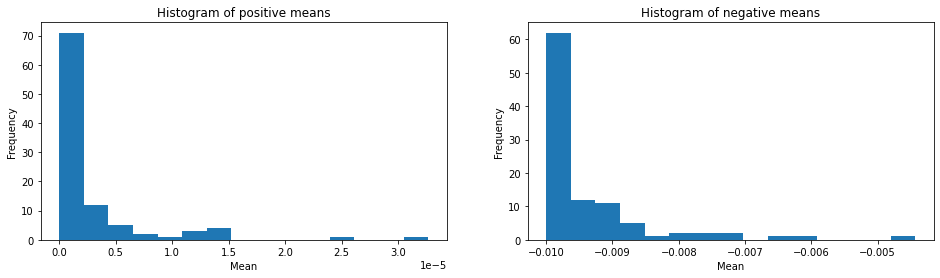

In [19]:
teste5 = find_several_critical_values(model_path_nn, sample_ben, "perimeter_mean",(min_v - (min_v * 1.5)),(max_v + (max_v * 1.5)),200, keep_n = 100)

In [20]:
print(len(teste4.metrics["critical_indexes"]))
print(len(teste5.metrics["critical_indexes"]))

78
99
